In [1]:
%matplotlib inline

In [11]:
import datetime
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from preparedata import prepare_train_data_for_task_1, prepare_dev_data_for_task_1, prepare_test_data_for_task_1
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [3]:
corpus = 'corpus-26'

_train_src, _, _train_tgt, _ = prepare_train_data_for_task_1(corpus= corpus)
_dev_src, _dev_tgt = prepare_dev_data_for_task_1(corpus= corpus)
_test_src = prepare_test_data_for_task_1(corpus= corpus)

train_src = _train_src[:]
dev_src = _dev_src[:]
test_src = _test_src[:]

labels = ['ALE', 'ALG', 'ALX', 'AMM', 'ASW', 'BAG', 'BAS', 'BEI', 'BEN',
       'CAI', 'DAM', 'DOH', 'FES', 'JED', 'JER', 'KHA', 'MOS', 'MSA',
       'MUS', 'RAB', 'RIY', 'SAL', 'SAN', 'SFX', 'TRI', 'TUN']

# labels = ['ALE', 'CAI']

train_tgt = [labels.index(tgt) for tgt in _train_tgt]
dev_tgt = [labels.index(tgt) for tgt in _dev_tgt]



# train_tgt = _train_tgt
# dev_tgt = _dev_tgt


In [4]:
1/len(labels)

0.038461538461538464

In [56]:
import json
import http.client
#from urllib.parse import urlencode

train_src = []
dev_src = []

conn = http.client.HTTPSConnection("farasa-api.qcri.org")
headers = { 'content-type': "application/json", 'cache-control': "no-cache", }

try:
    for sen in _train_src:
        normalized = sen.replace('"', '')
        payload = f'{{"text": "{normalized}"}}'
        conn.request("POST", "/msa/webapi/segmenter", payload.encode('utf-8'), headers)
        res = conn.getresponse()
        data = res.read()
        segmented_text = ' '.join(json.loads(data.decode("utf-8"))['segtext']).replace('+', ' ')

        train_src.append(segmented_text)

    for sen in _dev_src:
        normalized = sen.replace('"', '')
        payload = f'{{"text": "{normalized}"}}'
        conn.request("POST", "/msa/webapi/segmenter", payload.encode('utf-8'), headers)
        res = conn.getresponse()
        data = res.read()
        segmented_text = ' '.join(json.loads(data.decode("utf-8"))['segtext']).replace('+', ' ')

        dev_src.append(segmented_text)
except:
    print(sen)
    print(data.decode("utf-8"))
    

هو صندوق موسيقى .
{"segtext":["تكدر","تجي","تصلح+ها","؟"]}


In [5]:
len(_train_src)

41600

In [6]:
count_vec =CountVectorizer(analyzer='word',  min_df=1, max_df=0.95, ngram_range=(1, 1))
X_train_counts = count_vec.fit_transform(train_src)
X_dev_counts = count_vec.transform(dev_src)
X_test_counts = count_vec.transform(test_src)

tf_vec = TfidfTransformer(use_idf=False)

X_train_tf = tf_vec.fit_transform(X_train_counts)
X_dev_tf = tf_vec.transform(X_dev_counts)
X_test_tf = tf_vec.transform(X_test_counts)

tfidf_vect = TfidfTransformer(use_idf=True, smooth_idf=False, sublinear_tf=True)
X_train_tfidf = tfidf_vect.fit_transform(X_train_counts)
X_dev_tfidf = tfidf_vect.transform(X_dev_counts)
X_test_tfidf = tfidf_vect.transform(X_test_counts)

In [15]:
cp = [0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 
     0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 
     0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 
     0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 
     0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 0.038461538461538464, 
     0.038461538461538464]
clf_1 = MultinomialNB(alpha=0.3, fit_prior=False).fit(X_train_tfidf, train_tgt)

train_pred = clf_1.predict(X_train_tfidf)
dev_pred = clf_1.predict(X_dev_tfidf)
test_pred_1 = clf_1.predict(X_test_tfidf)

print('Training Acc: ',np.around(np.mean(train_pred == train_tgt)*100,2), '%')
print('Testing Acc: ',np.around(np.mean(dev_pred == dev_tgt)*100,2), '%')


currentDT = datetime.datetime.now()
time_stamp = currentDT.strftime("%Y%m%d%H%M%S")

with open(f'{corpus}/result/run_dev_np_{time_stamp}.G', mode='w') as prediction:
    for rs in dev_tgt:
        prediction.write(f'{labels[rs]}\n')
        
with open(f'{corpus}/result/run_dev_np_{time_stamp}.P', mode='w') as prediction:
    for rs in dev_pred:
        prediction.write(f'{labels[rs]}\n')

# Mohamed_Eldesouki1.subtask1.test
#<team><N>.subtask<i>.test
with open(f'{corpus}/result/run_test_np_{time_stamp}.P', mode='w') as prediction:
    for rs in test_pred_1:
        prediction.write(f'{labels[rs]}\n')

print(metrics.classification_report(dev_tgt, dev_pred))
np.sum(train_tgt)

Training Acc:  84.7 %
Testing Acc:  63.94 %
              precision    recall  f1-score   support

           0       0.64      0.59      0.62       200
           1       0.73      0.79      0.76       200
           2       0.73      0.77      0.74       200
           3       0.46      0.53      0.49       200
           4       0.48      0.59      0.53       200
           5       0.75      0.60      0.67       200
           6       0.69      0.65      0.67       200
           7       0.74      0.60      0.66       200
           8       0.69      0.73      0.71       200
           9       0.63      0.46      0.53       200
          10       0.64      0.55      0.59       200
          11       0.60      0.61      0.61       200
          12       0.61      0.69      0.64       200
          13       0.64      0.63      0.63       200
          14       0.47      0.58      0.52       200
          15       0.53      0.69      0.60       200
          16       0.83      0.79    

520000

NameError: name 'test_pred' is not defined

In [9]:


print ()
print (currentDT.strftime("%Y/%m/%d"))
print (currentDT.strftime("%H:%M:%S"))
print (currentDT.strftime("%I:%M:%S %p"))
print (currentDT.strftime("%a, %b %d, %Y"))

20190517204030
2019/05/17
20:40:30
08:40:30 PM
Fri, May 17, 2019



Normalized confusion matrix


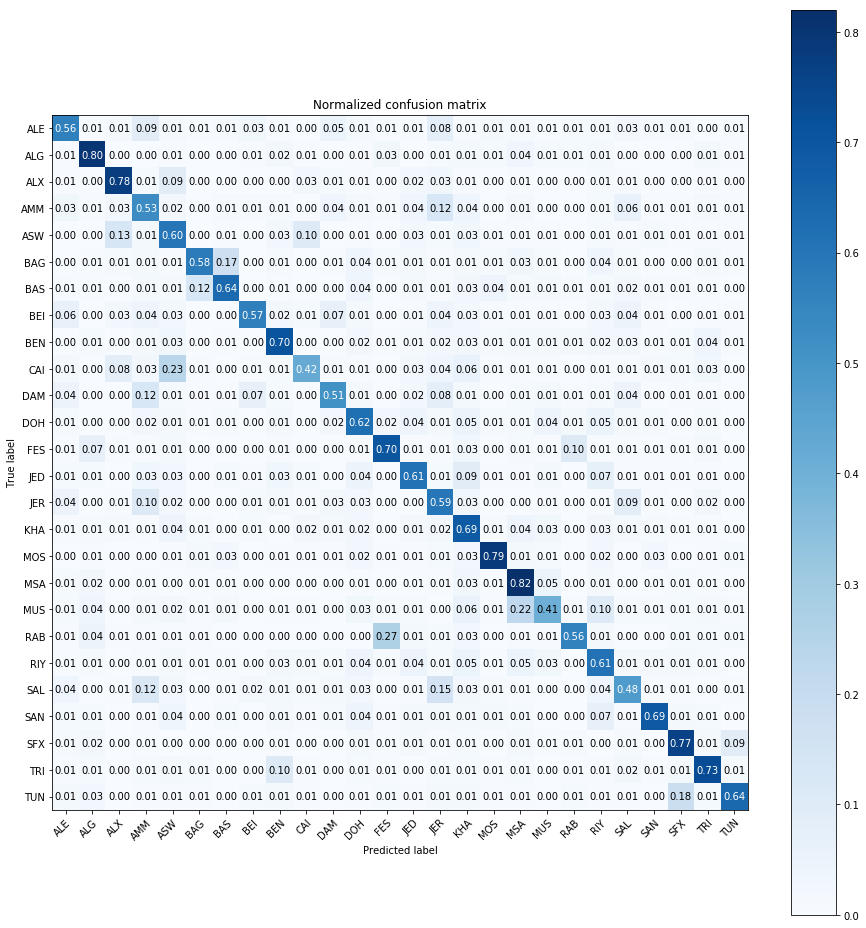

In [76]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
    else:
       print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(13,13))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print()
np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plot_confusion_matrix(dev_tgt, dev_pred, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
dt, dp = [], []
with open('corpus-26/result/run_dev_np_01.G') as g:
    for line in g:
        l = line.strip()
        dt.append(l)

with open('corpus-26/result/run_dev_np_01.P') as p:
    for line in p:
        l = line.strip()
        dp.append(l)
    
plot_confusion_matrix(dt, dp, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

In [77]:
clf_2 = SGDClassifier(n_jobs=-1)
clf_2.fit(X_train_tfidf, train_tgt)
train_pred = clf_2.predict(X_train_tfidf)
dev_pred = clf_2.predict(X_dev_tfidf)

print('Training Acc: ',np.around(np.mean(train_pred == train_tgt)*100,2), '%')
print('Testing Acc: ',np.around(np.mean(dev_pred == dev_tgt)*100,2), '%')

/home/disooqi/projects/MADAR-shared-task/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training Acc:  90.38 %
Testing Acc:  3.75 %


In [11]:
clf_3 = svm.SVC(kernel='linear', C=300)
clf_3.fit(X_train_tfidf, train_tgt)
train_pred = clf_3.predict(X_train_tfidf)
dev_pred = clf_3.predict(X_dev_tfidf)

print('Training Acc: ',np.around(np.mean(train_pred == train_tgt)*100,2), '%')
print('Testing Acc: ',np.around(np.mean(dev_pred == dev_tgt)*100,2), '%')

Training Acc:  89.9 %
Testing Acc:  46.94 %
